In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
import matplotlib.pyplot as plt
import numpy as np
import math
from scipy.stats import multivariate_normal
from IB import IB

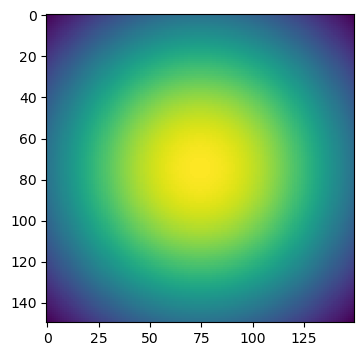

In [28]:
# create nondeterministic map 1
sizeX = 150
dimX = 2
sizeY = 2

X  = [(i,j) for i in range(sizeX) for j in range(sizeX)]
Y = [0,1]

px = np.array([[1./(sizeX*sizeX) for i in range(sizeX)] for j in range(sizeX)])


x1,x2 = np.meshgrid(np.linspace(-1,1,sizeX),np.linspace(-1,1,sizeX))
pos = np.dstack((x1, x2))
rv = multivariate_normal(cov = [[1,0],[0,1]])
py_x = np.empty(x1.shape + (2,))
py_x[:,:,1] = rv.pdf(pos)
py_x[:,:,1] = py_x[:,:,1]/max([max(p) for p in py_x[:,:,1]])
py_x[:,:,0] = -py_x[:,:,1] +1
pxy = py_x/np.sum(py_x)
plt.imshow(pxy[:,:,1])

In [29]:
qt_x, Ix_t, Iy_t, change, score,n  = IB(pxy, px, py_x, X,Y, 0.5, 100,0.1)


3


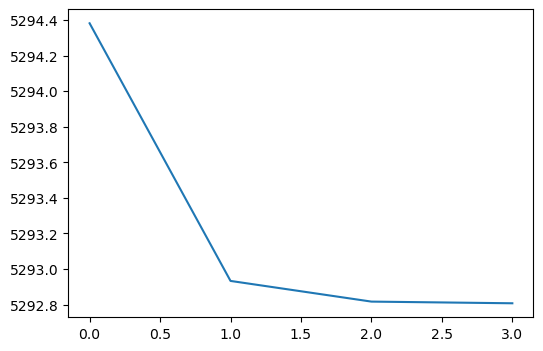

In [30]:
plt.plot(score[:n+1])
print(n)

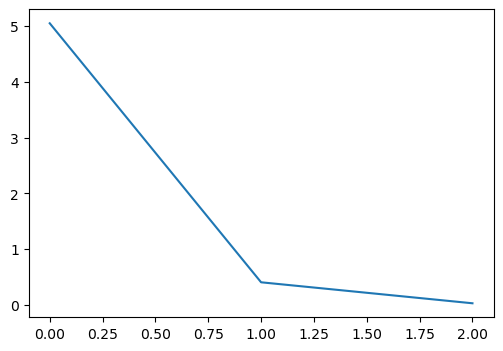

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
3


In [31]:
plt.plot(change[1:n+1])
plt.show()
print(change[-20:])
print(n)

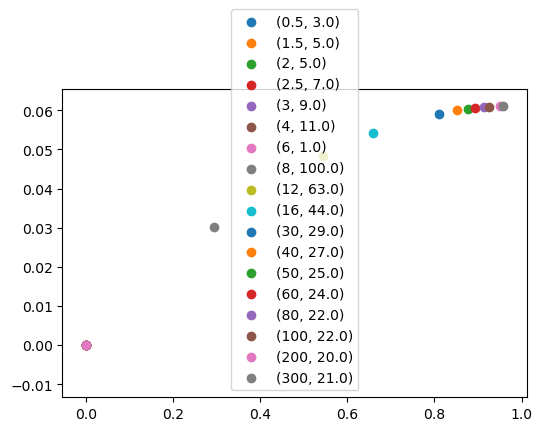

[  3.   5.   5.   7.   9.  11.   1. 100.  63.  44.  29.  27.  25.  24.
  22.  22.  20.  21.]


In [32]:
N=100
betas = [0.5,1.5,2,2.5,3,4,6,8,12,16,30,40,50,60,80,100,200,300]
b = len(betas)
changes = np.zeros((b,N))
scores = np.zeros((b,N))
qt_xs = np.zeros((b,)+ py_x.shape)
Ixts = np.zeros(b)
Iyts = np.zeros(b)
ns = np.zeros(b)
for i in range(b):
    qt_xs[i], Ixts[i], Iyts[i], changes[i,:], scores[i,:], ns[i] = IB(pxy, px, py_x, X,Y, betas[i], N)
    plt.scatter(Ixts[i],Iyts[i], label= (betas[i],ns[i]))
plt.legend()
plt.show()
print(ns)

In [33]:
_, Ixt200, Iyts200, _ ,_,n = IB(pxy, px, py_x, X,Y, 1000, N)
print(Ixt200, Iyts200)
print(n)

0.9699616995255778 0.061020251615020074
19


In [34]:
py = np.array([np.mean(py_x[:,:,y]) for y in Y])
Ixy = 0.
for y in Y:
    if py[y] > 0:
        for x in X:
            if py_x[x+(y,)] > 0:
                    Ixy += py_x[x+(y,)]*px[x]*math.log2(py_x[x+(y,)]/(py[y]))
print(Ixy)

0.09023495403791325


In [10]:

py_y = np.array([[np.sum(pxy[:,:,y]*py_x[:,:,t])/py[t] for y in Y] for t in Y ])
Iyy = 0.
for y in Y:
    if py[y] > 0:
        for t in Y:
            if py_y[t,y] > 0:
                Iyy += py_y[y,t]*py[t]*math.log2(py_y[y,t]/py[y])
print(Iyy)

0.5586335901415427


In [35]:
n = 100
x = np.linspace(0,1,n)
y = np.zeros(n)

for i in range(n):
    y[i] = Ixy

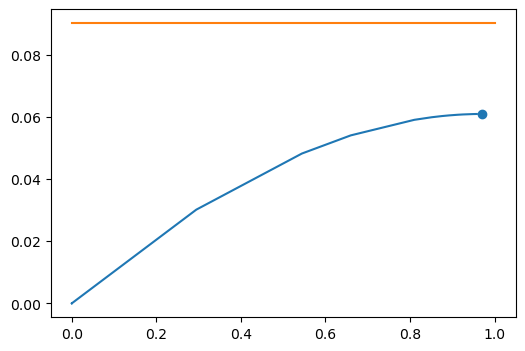

In [37]:
plt.plot(Ixts,Iyts)
plt.scatter(Ixt200,Iyts200)
plt.plot(x,y)
plt.show()

In [8]:
py = np.array([np.sum(pxy[:,:,y]) for y in Y])
Hy = sum(-py[y]*math.log2(py[y]) for y in Y)
print(Hy)

0.991911254613748


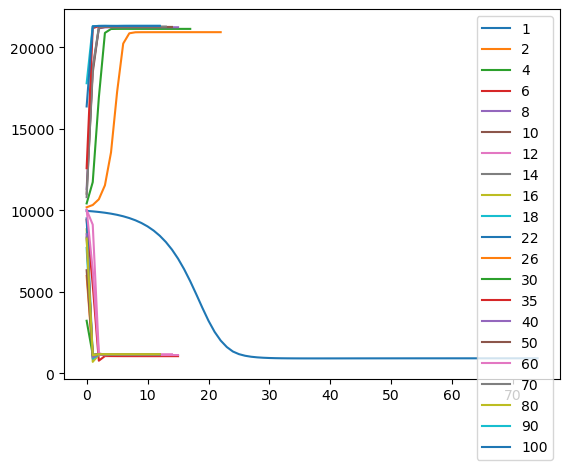

In [9]:
for i in range(b):
    plt.plot(scores[i,:int(ns[i])], label= betas[i])
plt.legend()
plt.show()

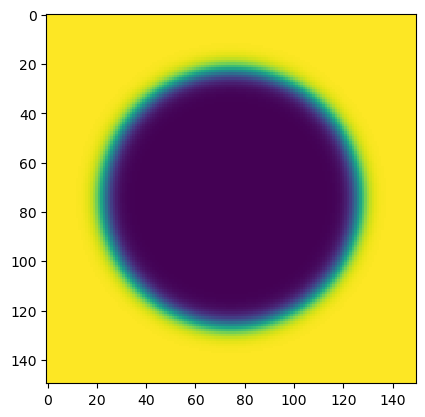

In [12]:
plt.imshow(qt_xs[10,:,:,1])
plt.show()

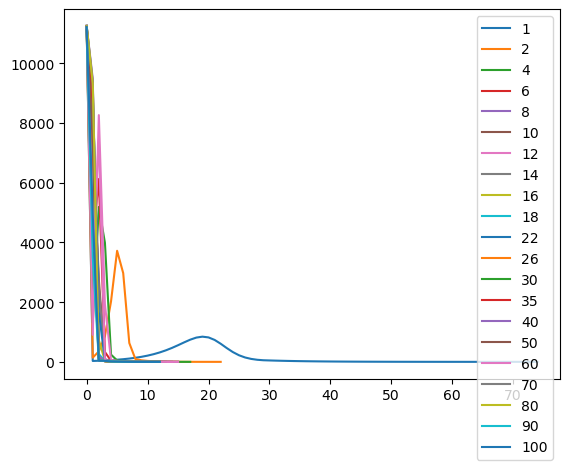

In [11]:
for i in range(b):
    plt.plot(changes[i,:int(ns[i])], label= betas[i])
plt.legend()
plt.show()

## Trees on nondeter data 


In [13]:
T = Y
# compute mutual information of X and T and Y and T
def mi(py_x_hat):
    pt = np.array([np.mean(py_x_hat[:,:,y]) for y in Y])
    Ixt = 0.
    for t in Y:
        if pt[t] > 0:
            for x in X:
                if py_x_hat[x+(t,)] > 0:
                        Ixt += py_x_hat[x+(t,)]*px[x]*math.log2(py_x_hat[x+(t,)]/pt[t])
        
    # compute mutual information of Y and T
    py = np.array([np.sum(pxy[:,:,y]) for y in Y])
    py_t = np.array([[np.sum(pxy[:,:,y]*py_x_hat[:,:,t])/pt[t] for y in Y] for t in T ])
    Iyt = 0.
    for y in Y:
        if py[y] > 0:
            for t in Y:
                if py_t[t,y] > 0:
                        Iyt += py_t[t,y]*pt[t]*math.log2(py_t[t,y]/py[y])
    return Ixt, Iyt

In [14]:
plt.rcParams['figure.figsize'] = [6, 4]

#### create training set 1

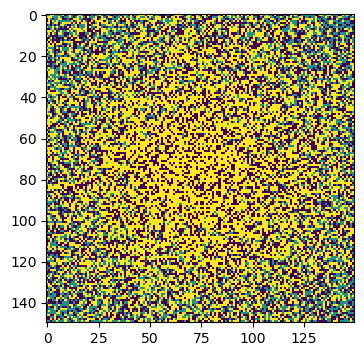

In [15]:


X_train, X_test = train_test_split(X, test_size=1/3.0)
train_size = len(X_train)
vect_py_x = np.zeros(train_size)
for i in range(train_size):
    if py_x[X_train[i]+(1,)] == 1:
        vect_py_x[i] =1
    elif py_x[X_train[i]+(1,)] == 0:
        vect_py_x[i] =0
    else:
        rnd = np.random.uniform(0., 1., 1)[0]
        if py_x[X_train[i]+(1,)] >= rnd:
            vect_py_x[i] =1
        elif py_x[X_train[i]+(1,)] < rnd:
            vect_py_x[i] =0
        
test_data = np.zeros((150,150)) -1
for i in range(train_size):
    test_data[X_train[i]] = vect_py_x[i]
plt.imshow(test_data)

#### train tree on training set 1

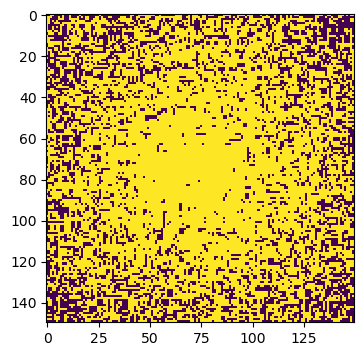

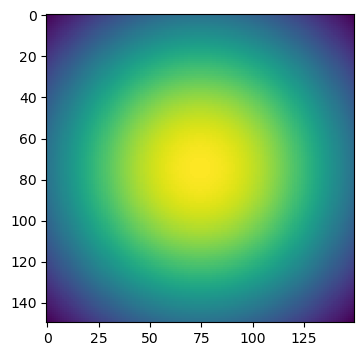

(0.8603692221010781, 0.008369136531767692)


In [16]:
clf = DecisionTreeClassifier(random_state=0)
clf.fit(X_train,vect_py_x)

vect_py_x_hat = clf.predict_proba(X)

py_x_hat = np.zeros((150,150,2)) 
for i in range(sizeX*sizeX):
    py_x_hat[X[i]] = vect_py_x_hat[i]
plt.imshow(py_x_hat[:,:,1])
plt.show()
plt.imshow(py_x[:,:,1])
plt.show()

Ixt, Iyt = mi(py_x_hat)
print((Ixt, Iyt))


In [16]:
0.6305545272883862

1224

#### train tree with pruning on training set 1

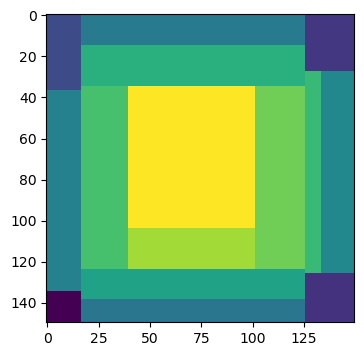

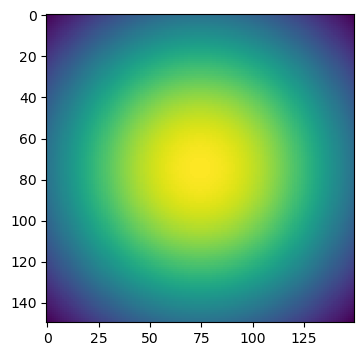

In [17]:
clf_p = DecisionTreeClassifier(random_state=0, ccp_alpha = 0.0005)#1e-04)
clf_p.fit(X_train,vect_py_x)

vect_py_x_hat_p = clf_p.predict_proba(X)

py_x_hat_p = np.zeros((150,150,2)) 
for i in range(sizeX*sizeX):
    py_x_hat_p[X[i]] = vect_py_x_hat_p[i]
plt.imshow(py_x_hat_p[:,:,1])
plt.show()
plt.imshow(py_x[:,:,1])
plt.show()


In [18]:
Ixt_p, Iyt_p = mi(py_x_hat_p)
print((Ixt_p, Iyt_p))

(0.08400397134096928, 0.0072511516647103605)


In [21]:
vect_Y_hat_p = np.array([[1-y,y] for y in clf_p.predict(X)])

Ixt_p2, Iyt_p2 = mi(vect_Y_hat_p)
print((Ixt_p2, Iyt_p2))

(0.9906912326402814, 0.631194281829899)


#### train tree on larger set (full image)

In [19]:
X_train2 = list()

for _ in range(5):
    X_train3, _ = train_test_split(X, test_size=1/3.0)
    X_train2 += X_train3

train2_size = len(X_train2)
vect_py_x2 = np.zeros(train2_size)

for i in range(train2_size):
    if py_x[X_train2[i]+(1,)] == 1:
        vect_py_x2[i] =1
    elif py_x[X_train2[i]+(1,)] == 0:
        vect_py_x2[i] =0
    else:
        rnd = np.random.uniform(0., 1., 1)[0]
        if py_x[X_train2[i]+(1,)] >= rnd:
            vect_py_x2[i] =1
        elif py_x[X_train2[i]+(1,)] < rnd:
            vect_py_x2[i] =0

In [44]:
len(X_train2)

75000

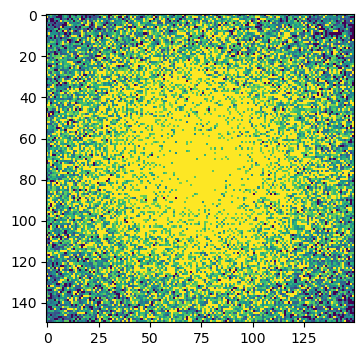

(0.3639577094285725, 0.00917603085756305)


In [20]:


clf_p2 = DecisionTreeClassifier(random_state=0)#, ccp_alpha = 1.5e-04)
clf_p2.fit(X_train2,vect_py_x2)

vect_py_x_hat_p2 = clf_p2.predict_proba(X)

py_x_hat_p2 = np.zeros((150,150,2)) 
for i in range(sizeX*sizeX):
    py_x_hat_p2[X[i]] = vect_py_x_hat_p2[i]
plt.imshow(py_x_hat_p2[:,:,1])
plt.show()
#plt.imshow(py_x[:,:,1])
#plt.show()
vect_Y_hat_p2 = np.array([[1-y,y] for y in clf_p2.predict(X)])

Ixt_p2, Iyt_p2 = mi(py_x_hat_p2)
print((Ixt_p2, Iyt_p2))

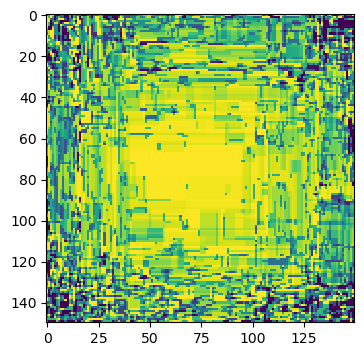

(0.29973782162803475, 0.008820005744679709)


In [21]:
rf = RandomForestClassifier(random_state=0,max_depth=15,n_estimators = 3)
rf.fit(X_train,vect_py_x)
vect_py_x_hat_rf = rf.predict_proba(X)

py_x_hat_rf = np.zeros((sizeX,sizeX,2)) 
for i in range(sizeX*sizeX):
    py_x_hat_rf[X[i]] = vect_py_x_hat_rf[i]
plt.imshow(py_x_hat_rf[:,:,1])
plt.show()
#plt.imshow(py_x[:,:,1])
#plt.show()
#vect_Y_hat_rf = np.array([[1-y,y] for y in rf.predict(X)])

Ixt_rf, Iyt_rf = mi(py_x_hat_rf)
print((Ixt_rf, Iyt_rf))

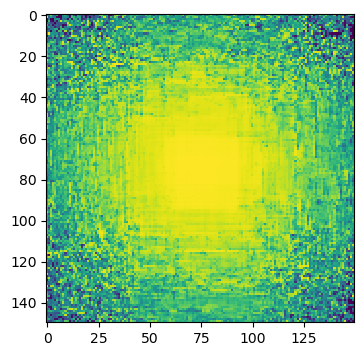

(0.14636034755351932, 0.009106582693396845)


In [22]:
rf2 = RandomForestClassifier(random_state=0,max_depth=15)
rf2.fit(X_train2,vect_py_x2)

vect_py_x_hat_rf2 = rf2.predict_proba(X)

py_x_hat_rf2 = np.zeros((150,150,2)) 
for i in range(sizeX*sizeX):
    py_x_hat_rf2[X[i]] = vect_py_x_hat_rf2[i]
plt.imshow(py_x_hat_rf2[:,:,1])
plt.show()
#plt.imshow(py_x[:,:,1])
#plt.show()
#vect_Y_hat_p2 = np.array([[1-y,y] for y in rf2.predict(X)])

Ixt_rf2, Iyt_rf2 = mi(py_x_hat_rf2)
print((Ixt_rf2, Iyt_rf2))

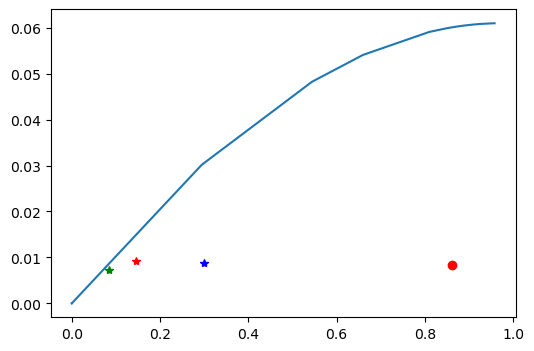

In [23]:

plt.plot(Ixts,Iyts)
plt.plot(Ixt, Iyt, 'ro')
plt.plot(Ixt_p,Iyt_p, 'g*')
plt.plot(Ixt_rf,Iyt_rf, 'b*')
plt.plot(Ixt_rf2,Iyt_rf2, 'r*')
plt.show()